In [2]:
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pyupbit

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, GlobalAveragePooling1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
def get_model(input_shape):
    input = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)(input)
    x = LSTM(64, return_sequences=True, activation='tanh', dropout=0.2)(x)
    x = LSTM(32, return_sequences=True, activation='tanh', dropout=0.2)(x)
    x = GlobalAveragePooling1D()(x)
    output = Dense(1)(x)
    model = Model(input, output)
    return model

In [5]:
WINDOW_SIZE = 6
feature_n = 6

Input_shape = (WINDOW_SIZE, feature_n)
model = get_model(Input_shape)
model.load_weights('./checkpoints/ckeckpointer.ckpt')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 128)            69120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 32)             12416     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_______________________________________________________

In [6]:
ticker = 'KRW-BTC'
interval ='minute10'
to = f'2021-11-10 00:10'
count = 1000

ori_df = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
ori_df


,open,high,low,close,volume,value
2021-11-03 01:30:00,75025000.0,75110000.0,74808000.0,74827000.0,42.323616,3.173048e+09
2021-11-03 01:40:00,74827000.0,74955000.0,74810000.0,74886000.0,26.774901,2.004494e+09
2021-11-03 01:50:00,74886000.0,75023000.0,74885000.0,74913000.0,27.888634,2.090929e+09
2021-11-03 02:00:00,74914000.0,75019000.0,74880000.0,74982000.0,29.500190,2.210531e+09
2021-11-03 02:10:00,74981000.0,74981000.0,74699000.0,74733000.0,24.260177,1.814633e+09
...,...,...,...,...,...,...
2021-11-09 23:20:00,81359000.0,81359000.0,81166000.0,81203000.0,54.985089,4.467551e+09
2021-11-09 23:30:00,81203000.0,81265000.0,81080000.0,81118000.0,46.954699,3.813998e+09
2021-11-09 23:40:00,81118000.0,81385000.0,80756000.0,80776000.0,60.260760,4.888984e+09
2021-11-09 23:50:00,80776000.0,80999000.0,80550000.0,80650000.0,99.310089,8.019597e+09


In [7]:
df = ori_df.reset_index(drop=True)
df

,open,high,low,close,volume,value
0,75025000.0,75110000.0,74808000.0,74827000.0,42.323616,3.173048e+09
1,74827000.0,74955000.0,74810000.0,74886000.0,26.774901,2.004494e+09
2,74886000.0,75023000.0,74885000.0,74913000.0,27.888634,2.090929e+09
3,74914000.0,75019000.0,74880000.0,74982000.0,29.500190,2.210531e+09
4,74981000.0,74981000.0,74699000.0,74733000.0,24.260177,1.814633e+09
...,...,...,...,...,...,...
995,81359000.0,81359000.0,81166000.0,81203000.0,54.985089,4.467551e+09
996,81203000.0,81265000.0,81080000.0,81118000.0,46.954699,3.813998e+09
997,81118000.0,81385000.0,80756000.0,80776000.0,60.260760,4.888984e+09
998,80776000.0,80999000.0,80550000.0,80650000.0,99.310089,8.019597e+09


In [8]:
drop_columns = ['value']

df = df.drop(columns=drop_columns)
df

,open,high,low,close,volume
0,75025000.0,75110000.0,74808000.0,74827000.0,42.323616
1,74827000.0,74955000.0,74810000.0,74886000.0,26.774901
2,74886000.0,75023000.0,74885000.0,74913000.0,27.888634
3,74914000.0,75019000.0,74880000.0,74982000.0,29.500190
4,74981000.0,74981000.0,74699000.0,74733000.0,24.260177
...,...,...,...,...,...
995,81359000.0,81359000.0,81166000.0,81203000.0,54.985089
996,81203000.0,81265000.0,81080000.0,81118000.0,46.954699
997,81118000.0,81385000.0,80756000.0,80776000.0,60.260760
998,80776000.0,80999000.0,80550000.0,80650000.0,99.310089


In [10]:
df['avg_price'] = (df['high'] + df['low'] + df['open'] + df['close'] ) // 4
data_df = df
data_df

,open,high,low,close,volume,avg_price
0,75025000.0,75110000.0,74808000.0,74827000.0,42.323616,74942500.0
1,74827000.0,74955000.0,74810000.0,74886000.0,26.774901,74869500.0
2,74886000.0,75023000.0,74885000.0,74913000.0,27.888634,74926750.0
3,74914000.0,75019000.0,74880000.0,74982000.0,29.500190,74948750.0
4,74981000.0,74981000.0,74699000.0,74733000.0,24.260177,74848500.0
...,...,...,...,...,...,...
995,81359000.0,81359000.0,81166000.0,81203000.0,54.985089,81271750.0
996,81203000.0,81265000.0,81080000.0,81118000.0,46.954699,81166500.0
997,81118000.0,81385000.0,80756000.0,80776000.0,60.260760,81008750.0
998,80776000.0,80999000.0,80550000.0,80650000.0,99.310089,80743750.0


In [12]:
after10 = np.zeros_like(df['close'])
for i in range(len(df['close']) - 1) :
        after10[i] = df['close'][i + 1]
        
df['after10'] = after10
df

,open,high,low,close,volume,avg_price,after10
0,75025000.0,75110000.0,74808000.0,74827000.0,42.323616,74942500.0,74886000.0
1,74827000.0,74955000.0,74810000.0,74886000.0,26.774901,74869500.0,74913000.0
2,74886000.0,75023000.0,74885000.0,74913000.0,27.888634,74926750.0,74982000.0
3,74914000.0,75019000.0,74880000.0,74982000.0,29.500190,74948750.0,74733000.0
4,74981000.0,74981000.0,74699000.0,74733000.0,24.260177,74848500.0,74529000.0
...,...,...,...,...,...,...,...
995,81359000.0,81359000.0,81166000.0,81203000.0,54.985089,81271750.0,81118000.0
996,81203000.0,81265000.0,81080000.0,81118000.0,46.954699,81166500.0,80776000.0
997,81118000.0,81385000.0,80756000.0,80776000.0,60.260760,81008750.0,80650000.0
998,80776000.0,80999000.0,80550000.0,80650000.0,99.310089,80743750.0,80441000.0


after10이 붙은 상태에서 minmax를 하면 0값 때문에 값이 이상해짐

In [13]:
norm = MinMaxScaler()
norm_np = norm.fit_transform(df)
norm_df = pd.DataFrame(norm_np, columns=list(df.columns))
norm_df

,open,high,low,close,volume,avg_price,after10
0,0.224190,0.218171,0.236572,0.203964,0.122389,0.214193,0.905525
1,0.204150,0.202204,0.236777,0.209930,0.074569,0.206586,0.905851
2,0.210121,0.209209,0.244465,0.212661,0.077994,0.212551,0.906686
3,0.212955,0.208797,0.243952,0.219638,0.082951,0.214844,0.903675
4,0.219737,0.204883,0.225400,0.194458,0.066835,0.204397,0.901208
...,...,...,...,...,...,...,...
995,0.865283,0.861867,0.888274,0.848721,0.161329,0.873730,0.980882
996,0.849494,0.852184,0.879459,0.840125,0.136632,0.862762,0.976747
997,0.840891,0.864545,0.846248,0.805542,0.177554,0.846324,0.975223
998,0.806275,0.824784,0.825133,0.792800,0.297649,0.818710,0.972696


In [356]:
norm = MinMaxScaler()
data_np = norm.fit_transform(data_df)
data_np = pd.DataFrame(data_np, columns=list(data_df.columns))
data_np

,open,high,low,close,volume,avg_price
0,0.224190,0.218171,0.236572,0.203964,0.122389,0.214193
1,0.204150,0.202204,0.236777,0.209930,0.074569,0.206586
2,0.210121,0.209209,0.244465,0.212661,0.077994,0.212551
3,0.212955,0.208797,0.243952,0.219638,0.082951,0.214844
4,0.219737,0.204883,0.225400,0.194458,0.066835,0.204397
...,...,...,...,...,...,...
995,0.865283,0.861867,0.888274,0.848721,0.161329,0.873730
996,0.849494,0.852184,0.879459,0.840125,0.136632,0.862762
997,0.840891,0.864545,0.846248,0.805542,0.177554,0.846324
998,0.806275,0.824784,0.825133,0.792800,0.297649,0.818710


In [357]:
after10 = np.zeros_like(df['close'])
for i in range(len(df['close']) - 1) :
        after10[i] = norm_df['close'][i + 1]
        
norm_df['after10'] = after10
label_df = norm_df['after10']
# df = df.drop([df.index[-1]])

norm_df

,open,high,low,close,volume,avg_price,after10
0,0.224190,0.218171,0.236572,0.203964,0.122389,0.214193,0.209930
1,0.204150,0.202204,0.236777,0.209930,0.074569,0.206586,0.212661
2,0.210121,0.209209,0.244465,0.212661,0.077994,0.212551,0.219638
3,0.212955,0.208797,0.243952,0.219638,0.082951,0.214844,0.194458
4,0.219737,0.204883,0.225400,0.194458,0.066835,0.204397,0.173830
...,...,...,...,...,...,...,...
995,0.865283,0.861867,0.888274,0.848721,0.161329,0.873730,0.840125
996,0.849494,0.852184,0.879459,0.840125,0.136632,0.862762,0.805542
997,0.840891,0.864545,0.846248,0.805542,0.177554,0.846324,0.792800
998,0.806275,0.824784,0.825133,0.792800,0.297649,0.818710,0.769744


In [358]:
data_np

,open,high,low,close,volume,avg_price
0,0.224190,0.218171,0.236572,0.203964,0.122389,0.214193
1,0.204150,0.202204,0.236777,0.209930,0.074569,0.206586
2,0.210121,0.209209,0.244465,0.212661,0.077994,0.212551
3,0.212955,0.208797,0.243952,0.219638,0.082951,0.214844
4,0.219737,0.204883,0.225400,0.194458,0.066835,0.204397
...,...,...,...,...,...,...
995,0.865283,0.861867,0.888274,0.848721,0.161329,0.873730
996,0.849494,0.852184,0.879459,0.840125,0.136632,0.862762
997,0.840891,0.864545,0.846248,0.805542,0.177554,0.846324
998,0.806275,0.824784,0.825133,0.792800,0.297649,0.818710


In [359]:
label_df

0      0.209930
1      0.212661
2      0.219638
3      0.194458
4      0.173830
         ...   
995    0.840125
996    0.805542
997    0.792800
998    0.769744
999    0.000000
Name: after10, Length: 1000, dtype: float64

In [360]:
def windowed_dataset(data, label, window_size, batch_size, shuffle):

    ds_x = tf.data.Dataset.from_tensor_slices(data)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    ds_y = tf.data.Dataset.from_tensor_slices(label[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [361]:
test = windowed_dataset(data_np, label_df, 6, 1, False)
for data in test.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(data[0])
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')
    print(data[1])

데이터셋(X) 구성(batch_size, window_size, feature갯수): (1, 6, 6)
tf.Tensor(
[[[0.22419028 0.21817058 0.23657237 0.203964   0.12238874 0.21419267]
  [0.2041498  0.20220437 0.23677737 0.20993023 0.07456903 0.20658573]
  [0.21012146 0.2092089  0.24446494 0.21266053 0.07799429 0.21255145]
  [0.21295547 0.20879687 0.24395244 0.21963798 0.0829506  0.21484395]
  [0.21973684 0.20488257 0.22539975 0.19445849 0.06683506 0.20439744]
  [0.19463563 0.1894314  0.20110701 0.17382951 0.11533618 0.18254051]]], shape=(1, 6, 6), dtype=float64)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (1,)
tf.Tensor([0.16988573], shape=(1,), dtype=float64)


In [362]:
pred = model.predict(test)
actual = np.asarray(label_df)[6:]

In [363]:
pred = pred[:,0]

In [364]:
print(pred.shape)
print(actual.shape)


(994,)
(994,)


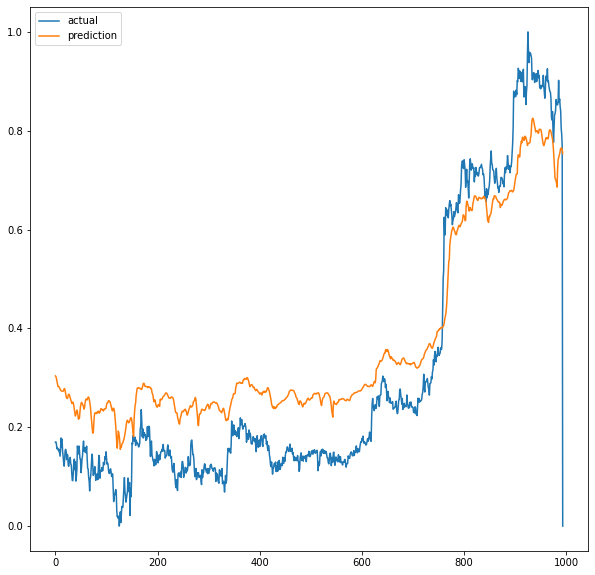

In [365]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [369]:
rate_pred = pred[-1]/pred[-2] 
# rate_pred = pred[-1]/actual[-2] 
print("이전 종가 : ", pred[-2])
# print("이전 종가 : ", actual[-2])
print("현재 예측 종가 : ", pred[-1])
print("비율 : ", rate_pred)
if rate_pred < 1 :
    print("Down")
else :
    print("Up")

이전 종가 :  0.76154023
현재 예측 종가 :  0.7537826
비율 :  0.9898132
Down


In [432]:
ticker = 'KRW-BTC'
interval ='minute10'
to = f'2021-11-10 00:20'
count = 2

test_up = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
test_up


,open,high,low,close,volume,value
2021-11-10 00:00:00,80650000.0,80688000.0,80277000.0,80441000.0,167.911427,1.351430e+10
2021-11-10 00:10:00,80441000.0,80487000.0,80300000.0,80381000.0,15.628903,1.256675e+09


In [433]:
rate = test_up['close'][-1] / test_up['close'][-2]
print(rate)

if rate < 1 :
    print("Down")
else :
    print("Up")

0.999254111709203
Down
